In [66]:
%matplotlib inline
from collections import defaultdict
import faiss
import torch
import faiss.contrib.torch_utils
from contextual_contrastive_projection_network import hyperparameters
from contextual_contrastive_projection_network.hyperparameters import HyperParameters
from contextual_contrastive_projection_network.mlp import ContrastiveMLP
from fewnerd_dataset import llm
from fewnerd_dataset.database import initialize_es, get_filtered_dataset
import matplotlib.pyplot as plt



In [67]:
def load_model(model_path: str, device: torch.device):
    hp = HyperParameters()
    model = ContrastiveMLP(args=hp)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model = model.eval()
    return model


In [68]:
async def fetch_test_dataset() -> list:
    es, _ = await initialize_es()
    test_dataset = await get_filtered_dataset(es, hyperparameters.TestTypes.types)
    return test_dataset



In [69]:
def plot_precision_results(precisions, labels, label_counts, description=""):

    plt.figure(figsize=(10, 6))
    bar_colors = ['orange' if label == "average" else 'C0' for label in labels]
    plt.bar([
        f"{label} ({label_counts[label]})" if label != "average" else label
        for label in labels
    ], precisions, color=bar_colors)
    plt.xlabel("Fine Type")
    plt.ylabel("Precision@r")
    plt.title(f"Precision@r for Each Fine Type, r is the number of distinct text phrases\n{description}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [70]:
class FewnerdEvalZeroShot:
    def __init__(self, dataset, model, device):
        self.dataset = dataset
        self.model = model
        self.device = device
        self.xb = self.build_dataset_index(dataset)
        self.xq = self.build_query_tensor()
        self.analyze_testset(dataset)

    def analyze_testset(self, dataset):
        self.text_id_to_labels, self.label_to_text_id = defaultdict(set), defaultdict(set)
        for doc in dataset:
            text_id = doc["_source"]["text_id"]
            fine_type = doc["_source"]["fine_type"]
            self.text_id_to_labels[text_id].add(fine_type)
            self.label_to_text_id[fine_type].add(text_id)

    def build_dataset_index(self, dataset):
        xb = [torch.tensor(doc["_source"]["llm_output"], device=self.device) for doc in dataset]
        xb = torch.stack(xb)
        with torch.no_grad():
            xb = self.model(xb)
        xb = torch.nn.functional.normalize(xb, p=2, dim=1)
        dim = xb[0].shape[0]
        index = faiss.IndexFlatIP(dim)
        index.add(xb.cpu().numpy())
        return index

    def build_query_tensor(self):
        xq = [llm.compute_llm_output(type).squeeze(0)[-1].to(self.device) for type in hyperparameters.TestTypes.types]
        xq = torch.stack(xq)
        with torch.no_grad():
            xq = self.model(xq)
        xq = torch.nn.functional.normalize(xq, p=2, dim=1)
        xq = xq.cpu().numpy()
        return xq

    def eval_zero_shot(self):
        k = self._get_max_label_count()
        D, I = self.xb.search(self.xq, k=3*k)
        precisions, labels = self._compute_precisions_labels(D, I, k)
        precisions, labels, label_counts = self._prepare_for_plot(precisions, labels)
        return precisions, labels, label_counts

    def _get_max_label_count(self):
        """Get the maximum number of text_ids for any label (used as k)."""
        return max(len(self.label_to_text_id[label]) for label in hyperparameters.TestTypes.types)

    def _compute_precisions_labels(self, D, I, k):
        """Compute precision@k and collect labels."""
        precisions = []
        labels = []
        for idx, label in enumerate(hyperparameters.TestTypes.types):
            relevant_text_ids = self.label_to_text_id[label]
            retrieved_text_ids = self.get_top_r_distinct_text_ids(I[idx], D[idx], k)
            assert len(retrieved_text_ids) == k
            num_correct = len(retrieved_text_ids & relevant_text_ids)
            precision = num_correct / k if k > 0 else 0
            precisions.append(precision)
            labels.append(label)
        avg_precision = sum(precisions) / len(precisions)
        precisions.append(avg_precision)
        labels.append("average")
        return precisions, labels

    def _prepare_for_plot(self, precisions, labels):
        """Sort results and prepare label counts for plotting."""
        sorted_results = sorted(zip(precisions, labels), key=lambda x: x[0], reverse=True)
        precisions, labels = zip(*sorted_results)
        label_counts = {label: len(self.label_to_text_id[label]) for label in labels if label != "average"}
        label_counts["average"] = 0
        return precisions, labels, label_counts

    def get_top_r_distinct_text_ids(self, retrieved_indices, sorting_order, r):
        retrieved_text_ids = set()
        sorted_results = sorted(zip(sorting_order, retrieved_indices), key=lambda x: x[0], reverse=True)
        sorting_order, retrieved_indices = zip(*sorted_results)
        for i in retrieved_indices:
            tid = self.dataset[i]["_source"]["text_id"]
            if tid not in retrieved_text_ids:
                retrieved_text_ids.add(tid)
            if len(retrieved_text_ids) == r:
                break
        return retrieved_text_ids


In [71]:
# Set up device and model



In [72]:
# Fetch test dataset
test_dataset = await fetch_test_dataset()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '../contrastive_projection_net.pth'

created mlp model:  Sequential(
  (0): Gate(dimension=1024)
  (1): Linear(in_features=1024, out_features=500, bias=True)
  (2): SiLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=500, out_features=500, bias=True)
)


/tmp/ipykernel_11606/423488158.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


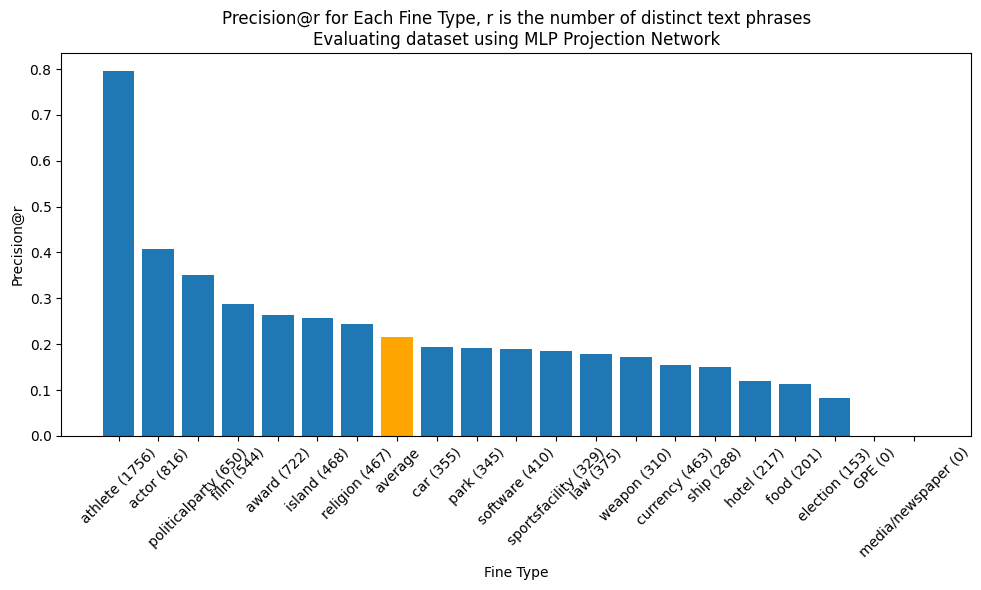

In [73]:
# Run evaluation and plot
description = "Evaluating dataset using MLP Projection Network"
model = load_model(model_path, device)
evaluator = FewnerdEvalZeroShot(test_dataset, model, device)
precisions, labels, label_counts = evaluator.eval_zero_shot()
plot_precision_results(precisions, labels, label_counts, description=description)


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7fb75f8e9d90>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7fb18ada8590>, 13343930.82901904)])']
connector: <aiohttp.connector.TCPConnector object at 0x7fb75f8e8fd0>


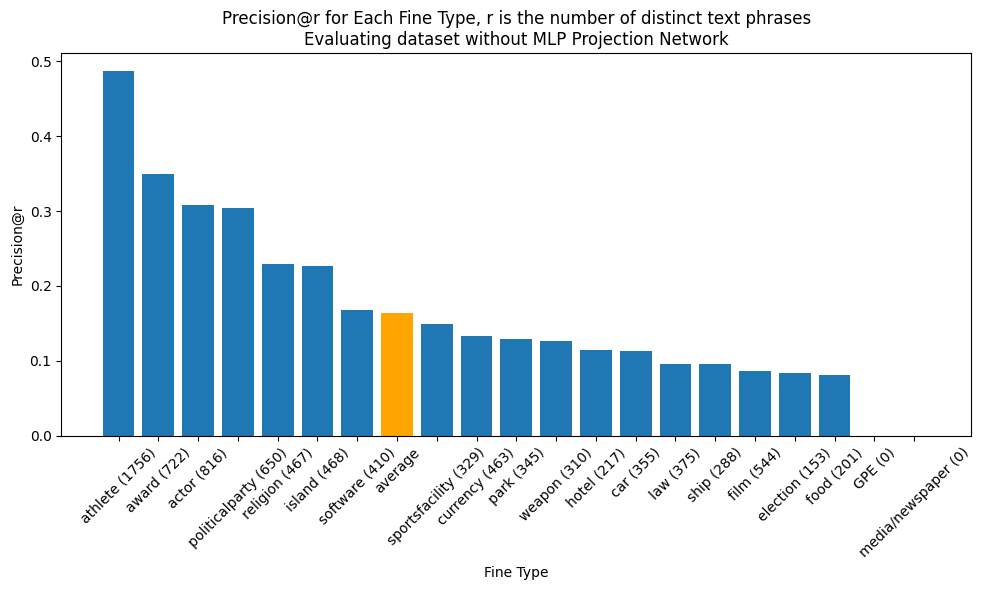

In [74]:
# Run evaluation and plot
description = "Evaluating dataset without MLP Projection Network"
model = torch.nn.Identity().to(device)  # Use identity model for no projection
evaluator = FewnerdEvalZeroShot(test_dataset, model, device)
precisions, labels, label_counts = evaluator.eval_zero_shot()
plot_precision_results(precisions, labels, label_counts, description=description)